In [48]:
import pandas as pd
import numpy as np
import cv2 as cv
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
from matplotlib.image import imread
import tensorflow_datasets as tfds

print("Pandas Version %s" %pd.__version__)
print("Numpy version %s" % np.__version__)
print("Tensorflow Version %s" % tf.__version__)
print("CV Version %s" % cv.__version__)

Pandas Version 1.1.5
Numpy version 1.19.2
Tensorflow Version 2.1.0
CV Version 4.5.1


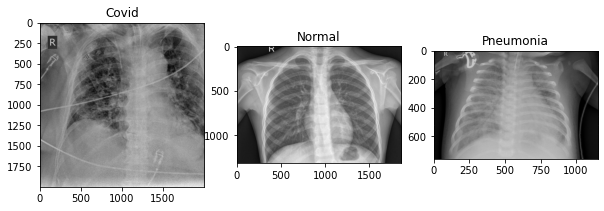

In [14]:
f,ax = plt.subplots(1,3,figsize=(10,8))
ax[0].imshow(imread("Data/Covid19.jpg"),"gray")
ax[0].set(title="Covid")
ax[1].imshow(imread("Data/NORMAL(0).jpg"),"gray")
ax[1].set(title="Normal")
ax[2].set(title="Pneumonia")
ax[2].imshow(imread("Data/PNEUMONIA(0).jpg"),"gray")

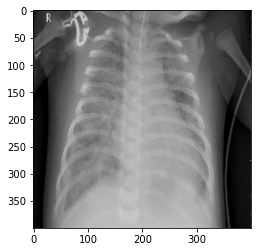

In [41]:
def preprocessImage(image):
    image = image / 255.0 
    image = cv.resize(image,(400,400))
    return image
plt.imshow(preprocessImage(imread("Data/PNEUMONIA(0).jpg"))) 

In [67]:
# Creating ResNet Architecthure

class identityBlockOne(tf.keras.Model):
    
    def __init__(self, filters : int, kernel_size : int):
        super(identityBlockOne,self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(filters,kernel_size,padding="SAME")
        self.batchNorm1 = tf.keras.layers.BatchNormalization()
        self.pooling1 = tf.keras.layers.MaxPool2D((3,3),padding="same")
    
        self.activation = tf.keras.layers.Activation(tf.nn.relu)
        self.add = tf.keras.layers.Add()
        
    def call (self, input_tensors):
        
        layer = self.conv1(input_tensors)
        for i in range(2):
            layer = self.conv1(layer)
            layer = self.activation(layer)
            layer = self.batchNorm1(layer)

        layer = self.add([layer,input_tensors])
        layer = self.activation(layer)
        return layer
    
class identityBlockTwo(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(identityBlockTwo,self).__init__()
        self.amountLoop = 5
        self.conv1 = tf.keras.layers.Conv2D(filters,kernel_size,padding="SAME")
        self.activation = tf.keras.layers.Activation(tf.nn.relu)
        self.pooling = tf.keras.layers.MaxPool2D((3,3))
        self.batchNormalization = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters,kernel_size)
        self.add = tf.keras.layers.Add()
    
    def call (self, input_tensors):

        layer = self.conv1(input_tensors)
        layer = self.activation(layer)
        layer = self.batchNormalization(layer)
        
        for i in range(self.amountLoop):
            layer = self.conv1(layer)
            layer = self.activation(layer)
            layer = self.batchNormalization(layer)
            
        layer = self.add([layer,input_tensors])
        layer = self.activation(layer)
        
        return layer


class ResNet(tf.keras.Model):
    
    def __init__(self, num_classes):
        super(ResNet,self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(64, 7, padding="SAME")
        self.batchNormalization = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.Activation(tf.nn.relu)
        self.max_pool = tf.keras.layers.MaxPool2D((3,3))
        
        self.id1 = identityBlockOne(64, 5)
        self.id2 = identityBlockTwo(64 ,5)
        
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation = tf.nn.softmax)
    
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.batchNormalization(x)
        x = self.activation(x)
        x = self.max_pool(x)
        
        x = self.id1(x)
        for i in range(0,3):
            x = self.id2(x)
        
        x = self.global_pool(x)
        
        return self.classifier(x)

In [69]:
def testPreprocess(features):
    return tf.cast(features["image"], tf.float32)/ 255, features['label'] 
resnet = ResNet(10)
resnet.compile('adam',loss="sparse_categorical_crossentropy",metrics=['accuracy'])

dataset = tfds.load('mnist',split=tfds.Split.TRAIN)
dataset = dataset.map(testPreprocess).batch(32)

history = resnet.fit(dataset,epochs=1)
print(history.history["accuracy"])

   1807/Unknown - 1347s 746ms/step - loss: 0.1578 - accuracy: 0.9525

KeyboardInterrupt: 